# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

### The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

### Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

In [ ]:
# !pip install jax

In [43]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Run this if you don't have a GPU
jax.config.update('jax_platform_name', 'cpu')

In [50]:
# First, we load the Fashion MNIST dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor()])
fashion_mnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Quick trick for getting the whole dataset as a single batch
dataloader = DataLoader(fashion_mnist, batch_size=len(fashion_mnist), shuffle=False)
X_train, y_train = next(iter(dataloader))

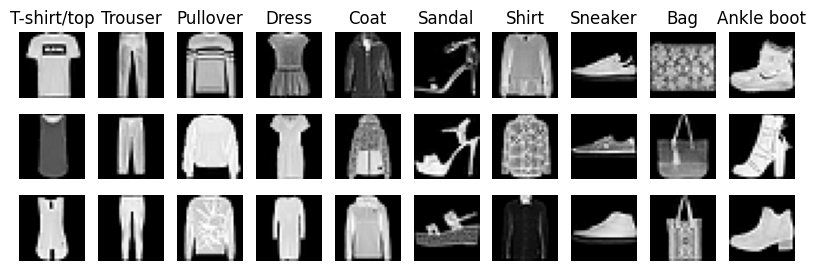

In [51]:
# Plot 3 x 10 unique label images
item_2_class = {i: c for i, c in enumerate(fashion_mnist.classes)}

fig, ax = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    ax[0, i].set_title(item_2_class[i])
    for j in range(3):
        ax[j, i].imshow(X_train[y_train == i][j].squeeze(), cmap='gray')
        ax[j, i].axis('off')
        
plt.show()

In [52]:
# Data preparation
X_train = jax.device_put(X_train.view(X_train.shape[0], -1).numpy())
y_train = jax.device_put(y_train.numpy())

def standardize(X):
    return (X - 0.1307) /  0.3081

X_train_scaled = standardize(X_train) # Important especially for PCA

print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 784)
y_train shape: (60000,)


In [57]:
# Start with Linear PCA, with n_components=3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled) # Projected X_train_scaled

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.29042003 0.17752895 0.06018882]
Total variance explained: 0.5281378


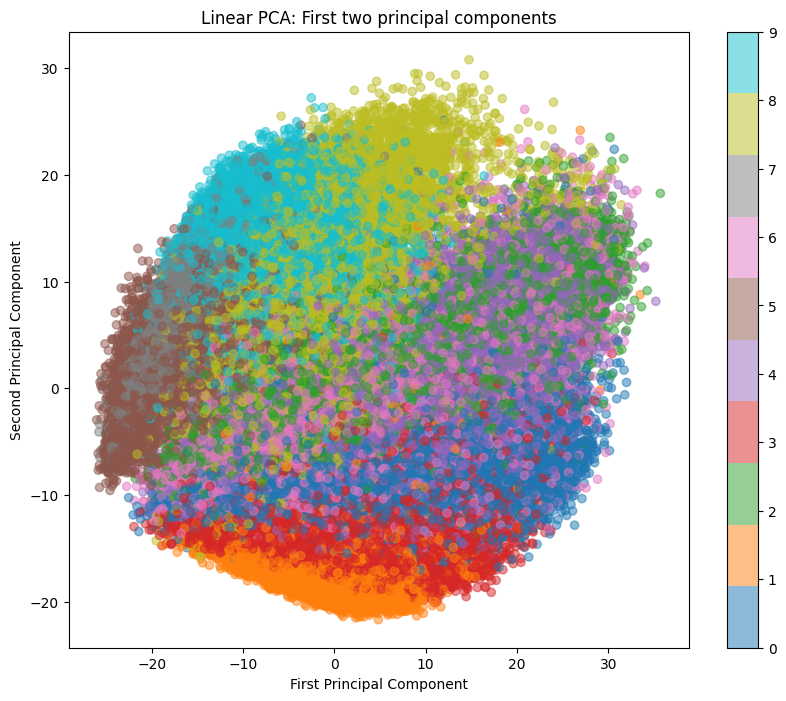

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [54]:
# First plot (2D)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=0.5)
plt.colorbar(scatter)
plt.title("Linear PCA: First two principal components")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()
print(item_2_class)

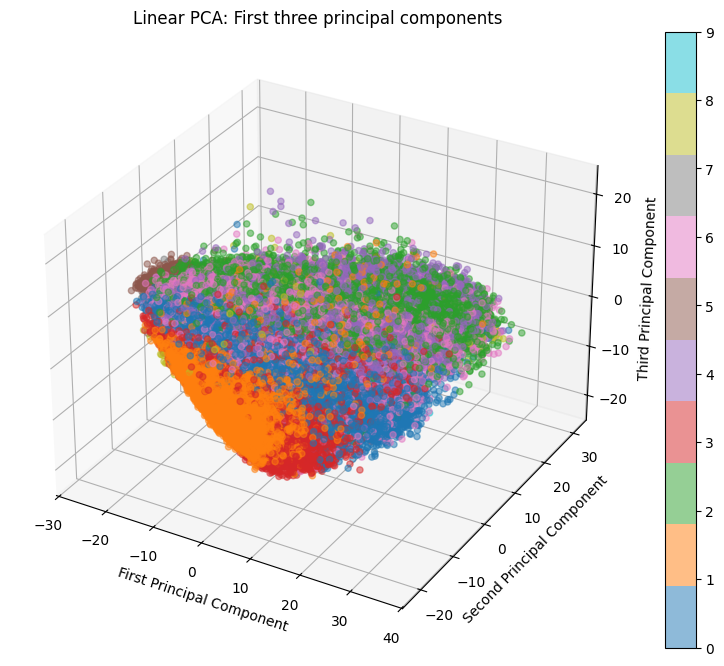

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [55]:
# 3D Plot for the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='tab10', alpha=0.5)
plt.colorbar(scatter)
plt.title("Linear PCA: First three principal components")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_zlabel("Third Principal Component")
plt.show()

print(item_2_class)

## Some observations

### Overall distribution:
The projected classes are superposed indicating that they are not perfectly separable using linear PCA. This suggests that the Fashion MNIST dataset has probably complex, non-linear relationships between classes.

### Specific observations on clusters
- The orange cluster (Trousers) is quite distinct, you can see it right in the 2D plot. This suggests that trousers have features that set them apart from other clothing items;

- The class in grey (Sneaker) overlaps with 5 (Sandal), and 9 (Ankle); that makes sense, and it's something we can expect;

- Classes blue (T-shirt/top), green (Pullover), purple (Coat), and pink (Shirt) seem to have considerable overlap. This makes sense as they are all upper body clothes with similar shapes

- The whole data is centered in zero, so the classes are a bit in opposition (plot in 2D);

- In 3D plot we see that is still overlapping, so we need more dimensions to correctly separate the data;

### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.


And please, avoid doing that... 👇🏻

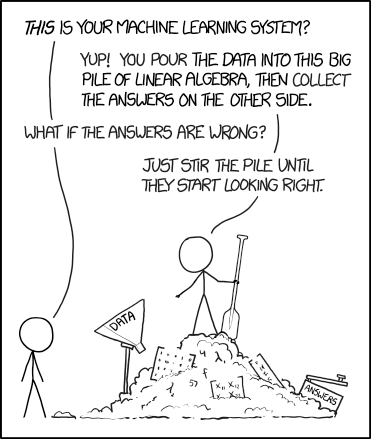